# <center>Structural Analysis and Visualization of Networks</center>

## <center>Home Assignment #1: Power law</center>

### <center>Student: Ilya Ivanitskiy</center>

#### <hr /> General Information

**Due Date:** 08.02.2016 23:59 <br \>
**Late submission policy:** -0.2 points per day <br \>


Please send your reports to <mailto:network.hse.2016@gmail.com> with message subject of the following structure:<br \> **[HSE Networks 2015] *{LastName}* *{First Name}* HA*{Number}***

Support your computations with figures and comments. <br \>
If you are using IPython Notebook you may use this file as a starting point of your report.<br \>
<br \>
<hr \>

## Problems

### Общий импорт библиотек

In [1]:
import pandas as pd
import numpy as np
import math, re, gc
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import *
from scipy import stats

### Task 1.

Load [wordcounts](http://www.leonidzhukov.net/hse/2015/networks/data/wordcounts.txt) dataset. 
1. Check that Zipf's Law holds
2. Assuming that the data is distributed according to the Power Law, find
 * $\alpha$ of the distribution
 * mean sample variance $\sigma^2$
3. Produce summary of the frequencies: min, max, mean, median

### Импорт данных

In [2]:
wc = pd.read_table('wordcounts.txt',sep=' ', header=None)
wc.columns = ['count_','word']

### Решение

### 1

In [3]:
wc['num'] = list(range(1,wc.shape[0]+1))
wc['num'] = 1/wc['num']
wc['freq'] = wc['count_']/sum(wc['count_'])
wc['num_norm'] = wc['num']/sum(wc['num'])
wc['fr_nu'] = np.abs(wc['freq'] - wc['num_norm'])

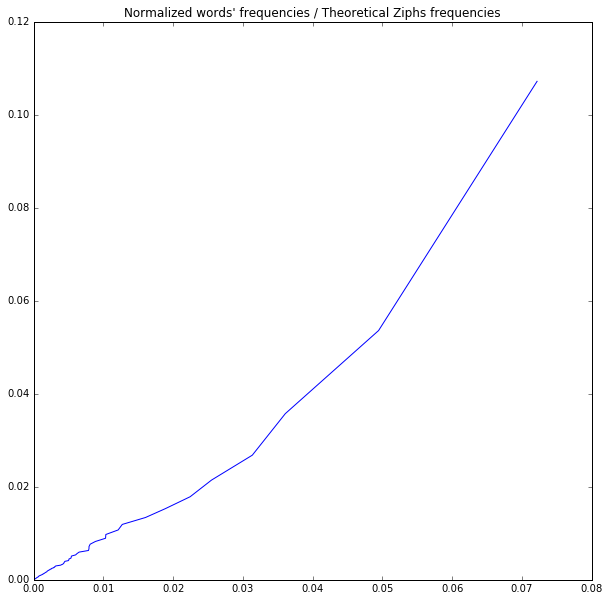

In [4]:
plt.figure(figsize=[10,10])
plt.title(u'Normalized words\' frequencies / Theoretical Ziphs frequencies' )
plt.plot(wc['freq'],wc['num_norm'])

In [5]:
hist_emp = np.histogram(np.log10(wc.freq), bins = 20)[0]
hist_th = np.histogram(np.log10(wc.num_norm),bins = 20)[0]

In [6]:
res_chi2 = chisquare(hist_emp, hist_th)
res_chi2

Power_divergenceResult(statistic=966.09320753091811, pvalue=9.1308898194664645e-193)

Так как p-value теста chi-2 мал, то мы можем утверждать, что распределение частот и распределение эмпирических частот в законе Ципфа совпадают.

In [7]:
# just for fun оценим коэффициент корреляции
np.corrcoef(wc['num_norm'],wc['freq'])
# он тоже достаточно близок к единице

array([[ 1.     ,  0.97271],
       [ 0.97271,  1.     ]])

### 2

In [8]:
alpha = 1+wc.shape[0]*(1/np.sum(np.log(wc.freq/min(wc.freq))))
print('estimate of alpha is	' + str(alpha))
sigma = math.sqrt(wc.shape[0])*(1/np.sum(np.log(wc.freq/min(wc.freq))))
print('estimate of sigma is	' + str(sigma))

estimate of alpha is	1.7194176300571224
estimate of sigma is	0.009050889560804583


### 3

In [9]:
print('minimum frequency in set is	' + str(np.min(wc['count_'])))
print('maximum frequency in set is	' + str(np.max(wc['count_'])))
print('median frequency in set is	' + str(np.median(wc['count_'])))
print('mean frequency in set is	' + str(np.mean(wc['count_'])))

minimum frequency in set is	800
maximum frequency in set is	6187267
median frequency in set is	2335.0
mean frequency in set is	13566.670781893004


### <hr /> Task 2.

Find and plot PDF and CDF for the following networks:
* [Routing network](http://www.leonidzhukov.net/hse/2015/networks/data/network.txt)
* [Web graph](http://www.leonidzhukov.net/hse/2015/networks/data/web_Stanford.txt)
* [Facebook network](http://www.leonidzhukov.net/hse/2015/networks/data/fb_Princeton.txt)


1. Are they correspondent to power law?
2. Find max and mean values of incoming and outcoming node degrees
3. Find $\alpha$ via Maximum Likelihood and calculate $\sigma^2$
4. Determine $x_{min}$ via Kolmogorov-Smirnov test

In [10]:
# преобразование графа в множество пар (степень вершины; количество вершин с такой степенью)
def f1(from_n,to_n,mode = 'd'):
    # index - count of edges
    # value - count of nodes
    if mode == 'd':
        return [ pd.Series(list(from_n.value_counts())).value_counts(), pd.Series(list(to_n.value_counts())).value_counts()]
    else:
        return pd.Series(list(pd.Series(list(from_n)+list(to_n)).value_counts())).value_counts()

In [29]:
# распределение степеней
def f2(x,y = None):
    if str(y) == 'None':
        plt.figure(figsize=[10,10])
        plt.grid(True)
        plt.plot(x.index,x.values,'*')
        #plt.show()
    else:
        plt.figure(figsize=[10,10])
        plt.grid(True)
        plt.plot(x.index,x.values,'g*')
        plt.plot(y.index,y.values,'r*')
        #plt.show()

In [12]:
def pdf(x):
    a = []
    b = []
    for i in range(len(x.values)):
        a.append(x.values[i])
        b.append(x.index[i]/sum(x.index))
    #plt.figure(figsize=[10,10])
    plt.title('pdf')
    plt.xlabel('value')
    plt.ylabel('probability')
    plt.plot(a,b)

In [13]:
def cdf_val(x):
    a = []
    b = []
    for i in range(len(x.index)):
        a.append(x.index[i])
        b.append(x.values[i]/sum(x.values))
    #plt.figure(figsize=[10,10])
    res = pd.Series(data = b, index = a)
    res = res.sort_index()
    res = res.cumsum()
    return res

In [14]:
def cdf(x):
    a = []
    b = []
    for i in range(len(x.index)):
        a.append(x.index[i])
        b.append(x.values[i]/sum(x.values))
    #plt.figure(figsize=[10,10])
    res = pd.Series(data = b, index = a)
    res = res.sort_index()
    res = res.cumsum()
    plt.title('cdf')
    plt.xlabel('value')
    plt.ylabel('cummulative probability')
    plt.plot(res.index,res.values)

In [15]:
def alpha_and_sigma(d,key = 'both'):
    # d - data frame [from, to]
    if key == 'both':
        temp = pd.Series(list(d.fr)+list(d.to)).value_counts()
    elif key == 'from':
        temp = pd.Series(list(d.fr)).value_counts()
    else:
        temp = pd.Series(list(d.to)).value_counts()
    # temp 
    #   value - количество входов/выходов
    #   index - id вершины
    alpha = 1+len(temp)*(1/np.sum(np.log(temp.values/min(temp.values))))
    print('estimate of alpha is	' + str(alpha))
    sigma = math.sqrt(len(temp))*(1/np.sum(np.log(temp.values/min(temp.values))))
    print('estimate of sigma is	' + str(sigma))
    return [alpha,sigma]

In [16]:
def search_xmin(d_distr,d,how = 'both'):
    # d_distr - степень каждой вершины
    # d - data frame [from, to]
    # how - 'from','to','both'
    x_mins = []
    sts = []
    pvs = []
    [alpha,sigma] = alpha_and_sigma(d,how)
    for x_min in set(d_distr.values):
        x_mins.append(x_min)
        temp = stats.kstest(
            d_distr[d_distr.values>=x_min],lambda a : 1.0 - ( a / x_min ) ** ( 1.0 - alpha )
            , N = len(d_distr[d_distr.values>=x_min]))
        sts.append(temp.statistic)
        pvs.append(temp.pvalue)
    plt.figure(figsize=[10,10])
    plt.plot(x_mins,sts,'*')
    plt.xlabel('x_min')
    plt.ylabel('statistics')
    return [x_mins, sts,pvs]  

### Считывание данных

In [17]:
d1 = pd.read_table('network.txt',sep=' ', header=None,comment='#')
d2 = pd.read_table('web_Stanford.txt',sep='	', header=None,comment='#')
d3 = pd.read_table('fb_Princeton.txt',sep=' ', header=None,comment='#')

Так как из d1, d2 и d3 ориентированным является только d2, то степени in и out стоит считать только для него.
Для d1 и d3 стоит брать общую степень вершины.

In [18]:
d1.columns = ['fr','to']
d2.columns = ['fr','to']
d3.columns = ['fr','to']

In [19]:
d1_nd = f1(d1.fr,d1.to,'u')
d2_nd = f1(d2.fr,d2.to,'d')
d3_nd = f1(d3.fr,d3.to,'u')

### PDF and CDF

network.txt
Routing Network
unoriented


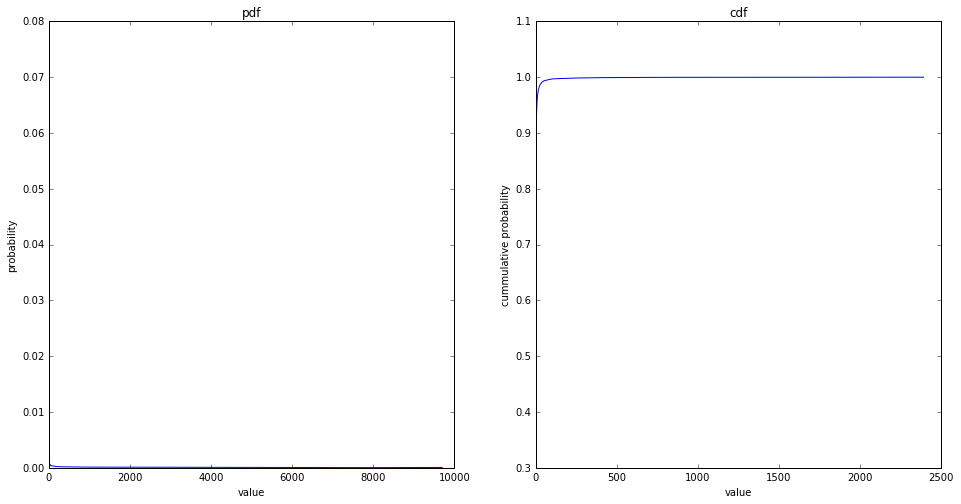

In [20]:
print('network.txt')
print('Routing Network')
print('unoriented')
plt.figure(figsize=[16,8])
plt.subplot (1, 2, 1)
pdf(d1_nd)
plt.subplot (1, 2, 2)
cdf(d1_nd)

web_Stanford.txt
Web graph
outcome


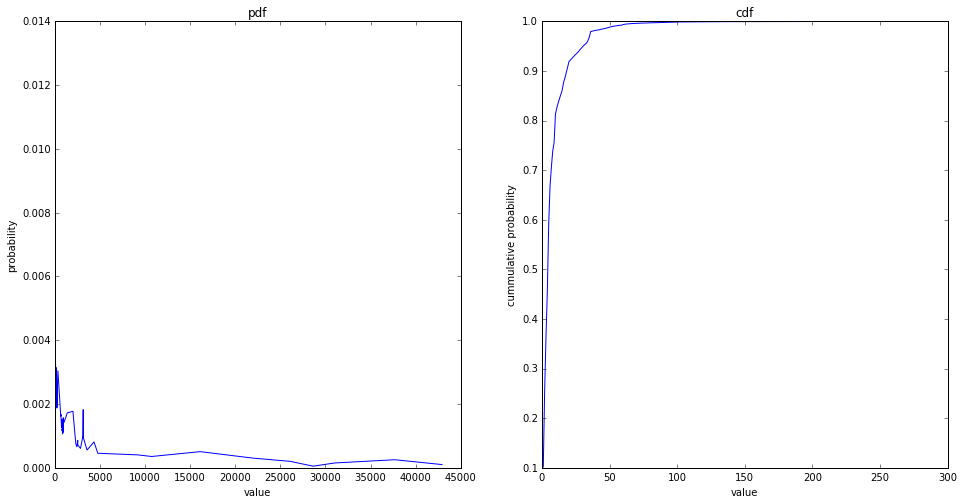

In [21]:
print('web_Stanford.txt')
print('Web graph')
print('outcome')
plt.figure(figsize=[16,8])
plt.subplot (1, 2, 1)
pdf(d2_nd[0])
plt.subplot (1, 2, 2)
cdf(d2_nd[0])

web_Stanford.txt
Web graph
income


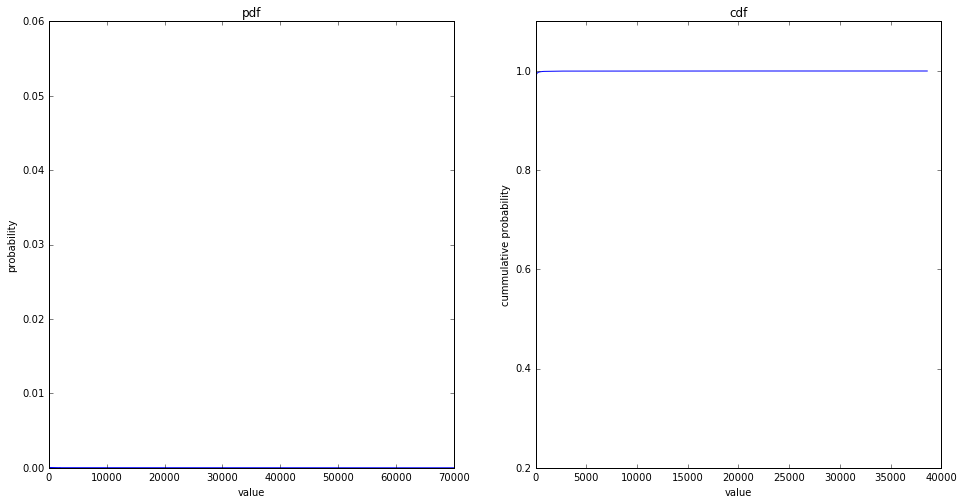

In [22]:
print('web_Stanford.txt')
print('Web graph')
print('income')
plt.figure(figsize=[16,8])
plt.subplot (1, 2, 1)
pdf(d2_nd[1])
plt.subplot (1, 2, 2)
cdf(d2_nd[1])

fb_Princeton.txt
Facebook network
unoriented


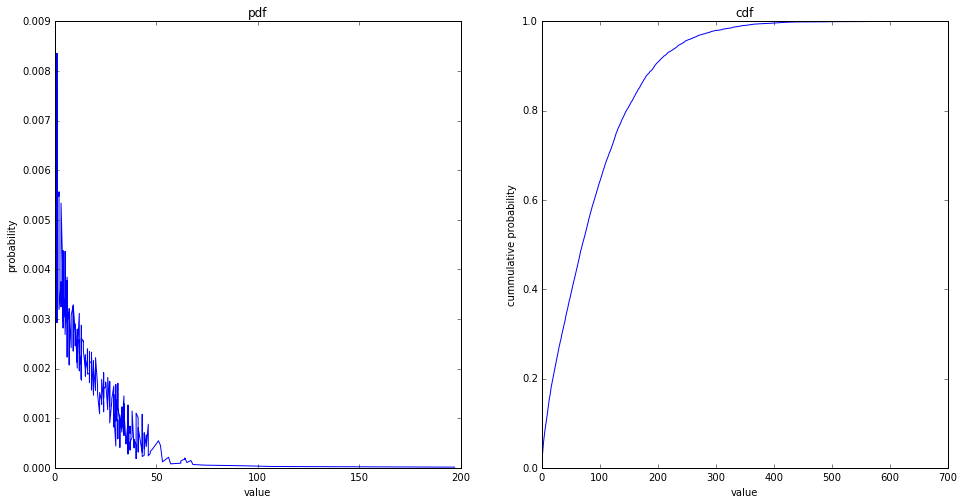

In [24]:
print('fb_Princeton.txt')
print('Facebook network')
print('unoriented')
plt.figure(figsize=[16,8])
plt.subplot (1, 2, 1)
pdf(d3_nd)
plt.subplot (1, 2, 2)
cdf(d3_nd)

### 1

network.txt
Routing Network
unoriented


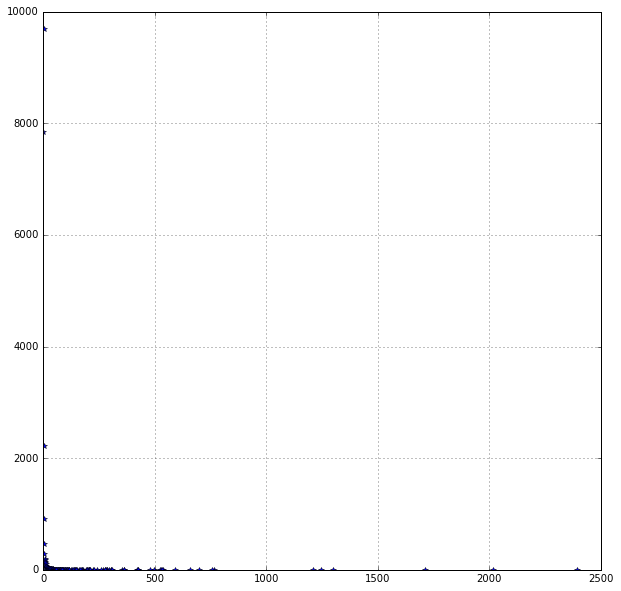

In [30]:
print('network.txt')
print('Routing Network')
print('unoriented')
f2(d1_nd)

web_Stanford.txt
Web graph
oriented


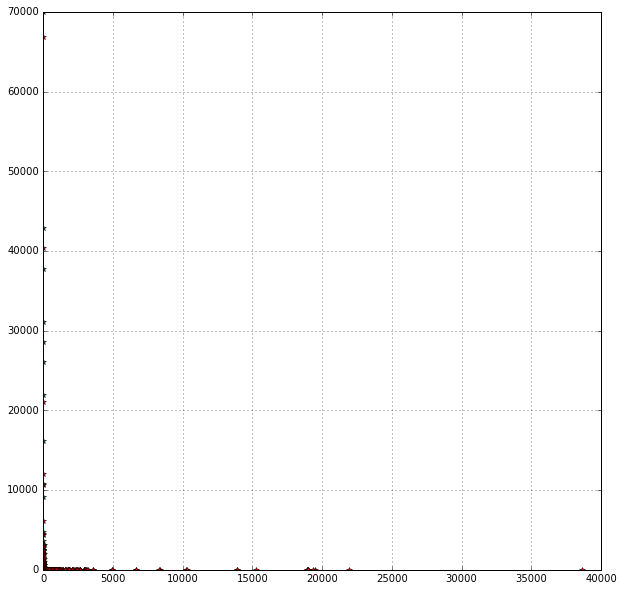

In [31]:
print('web_Stanford.txt')
print('Web graph')
print('oriented')
f2(d2_nd[0],d2_nd[1])

fb_Princeton.txt
Facebook network
unoriented


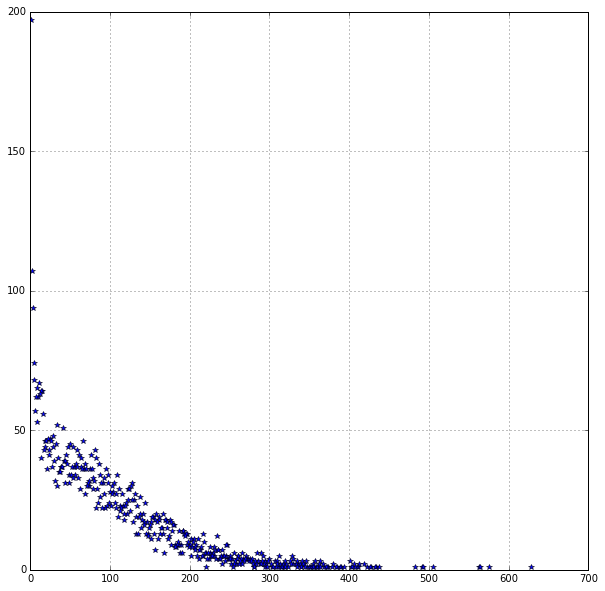

In [32]:
print('fb_Princeton.txt')
print('Facebook network')
print('unoriented')
f2(d3_nd)

### 2

In [33]:
#
print('network.txt')
print('Routing Network')
print('unoriented')
print('min '+ str(min(d1_nd.index)))
print('max '+ str(max(d1_nd.index)))

network.txt
Routing Network
unoriented
min 1
max 2390


In [34]:
#
print('web_Stanford.txt')
print('Web graph')
print('outcome')
print('min '+ str(min(d2_nd[0].index)))
print('max '+ str(max(d2_nd[0].index)))

web_Stanford.txt
Web graph
outcome
min 1
max 255


In [35]:
#
print('web_Stanford.txt')
print('Web graph')
print('income')
print('min '+ str(min(d2_nd[1].index)))
print('max '+ str(max(d2_nd[1].index)))

web_Stanford.txt
Web graph
income
min 1
max 38606


In [36]:
#
print('fb_Princeton.txt')
print('Facebook network')
print('unoriented')
print('min '+ str(min(d3_nd.index)))
print('max '+ str(max(d3_nd.index)))

fb_Princeton.txt
Facebook network
unoriented
min 1
max 628


### 3

In [37]:
print('network.txt')
print('Routing Network')
print('unoriented')
alpha_and_sigma(d1)

network.txt
Routing Network
unoriented
estimate of alpha is	2.43517175294
estimate of sigma is	0.009470863233


[2.4351717529396106, 0.0094708632330031059]

In [38]:
print('web_Stanford.txt')
print('Web graph')
print('outcome')
alpha_and_sigma(d2,'from')

web_Stanford.txt
Web graph
outcome
estimate of alpha is	1.62618016321
estimate of sigma is	0.00117972827126


[1.6261801632068593, 0.0011797282712577544]

In [39]:
print('web_Stanford.txt')
print('Web graph')
print('income')
alpha_and_sigma(d2,'to')

web_Stanford.txt
Web graph
income
estimate of alpha is	1.95412784401
estimate of sigma is	0.00186551034276


[1.9541278440114227, 0.0018655103427559663]

In [40]:
print('fb_Princeton.txt')
print('Facebook network')
print('unoriented')
alpha_and_sigma(d3)

fb_Princeton.txt
Facebook network
unoriented
estimate of alpha is	1.255330766
estimate of sigma is	0.00314385729638


[1.2553307659981887, 0.0031438572963802436]

### 4

In [41]:
d1_distr =  pd.Series(list(d1.fr)+list(d1.to)).value_counts().sort_values()
d2_from_distr =  pd.Series(list(d2.fr)).value_counts().sort_values()
d2_to_distr =  pd.Series(list(d2.to)).value_counts().sort_values()
d3_distr =  pd.Series(list(d3.fr)+list(d3.to)).value_counts().sort_values()

network.txt
Routing Network
unoriented
estimate of alpha is	2.43517175294
estimate of sigma is	0.009470863233
optimal x_min is 19


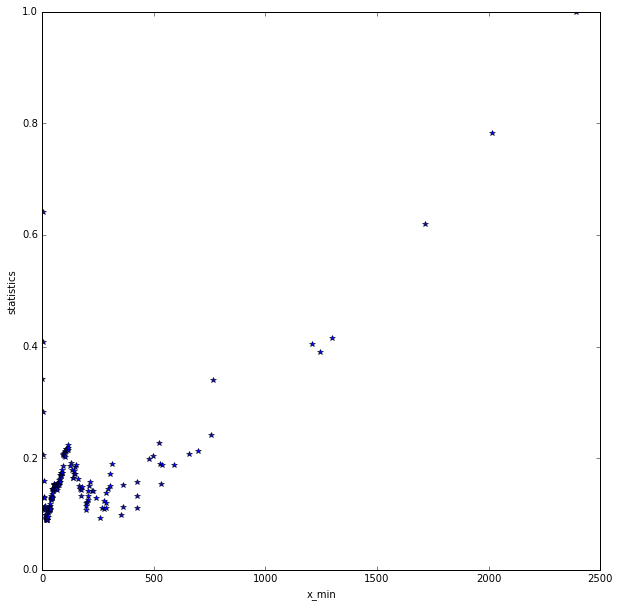

In [42]:
print('network.txt')
print('Routing Network')
print('unoriented')
[x_s,st_s,pvs] = search_xmin(d1_distr,d1,'both')
print('optimal x_min is ' + str(x_s[st_s.index(min(st_s))]))

web_Stanford.txt
Web graph
from
estimate of alpha is	1.62618016321
estimate of sigma is	0.00117972827126
optimal x_min is 2


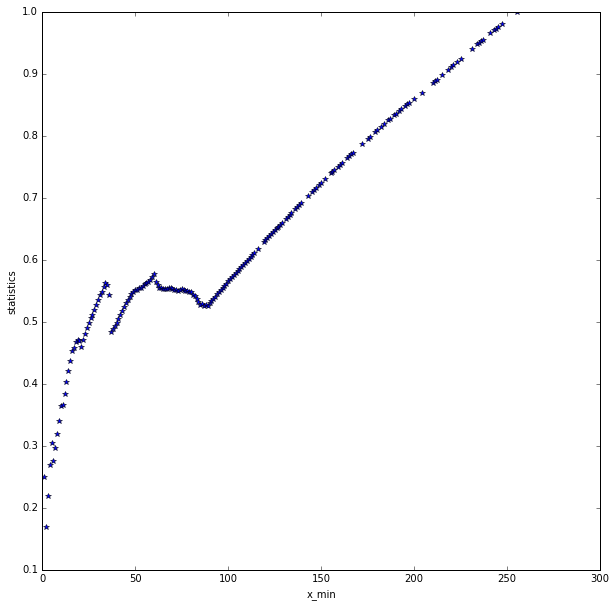

In [43]:
print('web_Stanford.txt')
print('Web graph')
print('from')
[x_s,st_s,pvs] = search_xmin(d2_from_distr,d2,'from')
print('optimal x_min is ' + str(x_s[st_s.index(min(st_s))]))

web_Stanford.txt
Web graph
to
estimate of alpha is	1.95412784401
estimate of sigma is	0.00186551034276
optimal x_min is 168


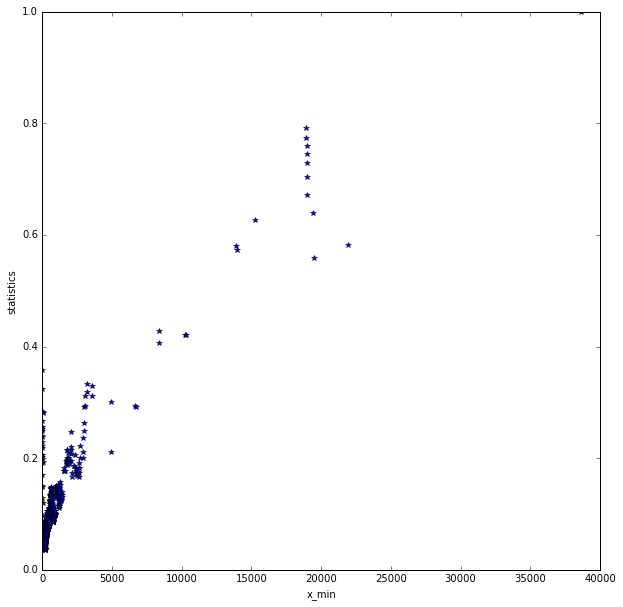

In [44]:
print('web_Stanford.txt')
print('Web graph')
print('to')
[x_s,st_s,pvs] = search_xmin(d2_to_distr,d2,'to')
print('optimal x_min is ' + str(x_s[st_s.index(min(st_s))]))

fb_Princeton.txt
Facebook network
unoriented
estimate of alpha is	1.255330766
estimate of sigma is	0.00314385729638
optimal x_min is 2


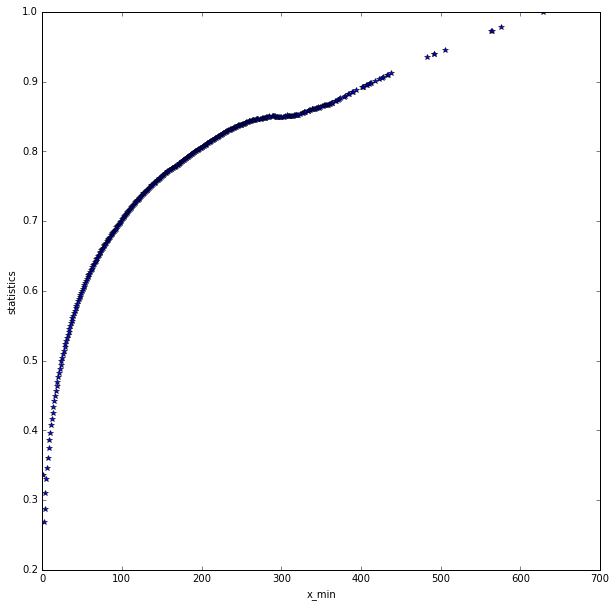

In [45]:
print('fb_Princeton.txt')
print('Facebook network')
print('unoriented')
[x_s,st_s,pvs] = search_xmin(d3_distr,d3)
print('optimal x_min is ' + str(x_s[st_s.index(min(st_s))]))

# The end